# Single Qubit Kraus-Decomposition 

A key insight is that we can engineer a noisy process which acts on an *arbitrary* unitary U. Here, we try to determine the unitary which encodes our process by solving a system of integral equations. 

Computing the fourier expansions of our functions. The vision is that we compute them numerically using integral methods, with q as the input

In [1]:
from scipy import integrate
import numpy as np


def compute_fourier_expansions(q,init_E, init_nz, ECos, ESin, nzCos, nzSin):
    en_gen = init_E 
    # This computes the ... phase? inside the cos term of the integrand 
    for i in np.arange(len(ECos)): # Ecos and Esin should be of the same length
        en_gen += ECos[i]*np.cos(i*q) + ESin[i]*np.sin(i*q)

    nz_gen = init_nz
    #Same deal as before
    for i in np.arange(len(ECos)): # Ecos and Esin should be of the same length
        nz_gen += nzCos[i]*np.cos(i*q) + nzSin[i]*np.sin(i*q)
    
    return en_gen, nz_gen

def compute_en(q, init_E, ECos, ESin):
    en_gen = init_E 
    # This computes the ... phase? inside the cos term of the integrand 
    for i in np.arange(len(ECos)): # Ecos and Esin should be of the same length
        en_gen += ECos[i]*np.cos(i*q) + ESin[i]*np.sin(i*q)
        
    return en_gen

def compute_nz(q, init_nz, nzCos, nzSin):
    nz_gen = init_nz
    # This computes the ... phase? inside the cos term of the integrand 
    for i in np.arange(len(nzCos)): # Ecos and Esin should be of the same length
        nz_gen += nzCos[i]*np.cos(i*q) + nzSin[i]*np.sin(i*q)
    return nz_gen 

def first_integrand(q, init_E, ECos, ESin):
    en_gen = compute_en(q, init_E, ECos, ESin)
    return np.cos(en_gen)**2

def second_integrand(q, init_E, init_nz,  ECos, ESin, nzCos, nzSin):
    en_gen = compute_en(q, init_E, ECos, ESin)
    nz_gen = compute_nz(q, init_nz, nzCos, nzSin)
    
    return (nz_gen*np.sin(en_gen))**2

def compute_loss_func(init_E, init_nz, Ecos, Esin, nzCos, nzSin):
    integral_one = integrate.quad(first_integrand, -np.pi, np.pi, args=(init_E, Ecos, Esin))[0]
    integral_two = integrate.quad(second_integrand, -np.pi, np.pi, args=(init_E, init_nz, Ecos, Esin, nzCos, nzSin))[0]
    
    return np.abs(1 - (integral_one + integral_two))
    

Additional helper functions for the genetic algoritm 

In [2]:
# There are n_coeffs coefficients for Ecos, n_coeffs coefficients for Esin, same for both nzCos and nzSin, and 2 for the initial En and nz values. 
# In all, we have 4*n_coeff + 2 coeffcients we have to consider 

n_coeffs = 5

funky = np.random.rand(4*n_coeffs+2)

def assign_coeffs(n_coeffs, coeffs):
    
    init_E = coeffs[0]
    init_nz = coeffs[1]
    Ecos = coeffs[1:n_coeffs+1]
    Esin = coeffs[n_coeffs+1:2*n_coeffs+1]
    nzCos = coeffs[2*n_coeffs+1: 3*n_coeffs+1]
    nzSin = coeffs[3*n_coeffs+1:4*n_coeffs+1]
    
    return init_E, init_nz, Ecos, Esin, nzCos, nzSin 


# Made for the PyGAD class
# ga_instance - this is the instance of the pygad.GA class that stores all of our hyperparameters (?)
# solution - these would be the parameters for which we are optimizing for. Change the fitness_batch_size to accept multiple solutions 
# solution_idx - indices of solution in the population. 

def the_fitness_function(ga_instance, solution, solution_idx):
    init_E, init_nz, Ecos, Esin, nzCos, nzSin = assign_coeffs(n_coeffs, solution)
    fitness = compute_loss_func(init_E, init_nz, Ecos, Esin, nzCos, nzSin)
    return -fitness
  

Let's test this out! 

In [3]:
#To test...
num_of_coeffs = 15

init_E = 0.1
ECos = np.random.rand(num_of_coeffs)
ESin = np.random.rand(num_of_coeffs)

init_nz = 0.2
nzCos = np.random.rand(num_of_coeffs)
nzSin = np.random.rand(num_of_coeffs)

#Now, compute the loss function 

compute_loss_func(init_E, init_nz, ECos, ESin, nzCos, nzSin)


19.340499265878027

## Genetic Algorithm 

Start by preparing the parameters for the genetic algorithm 

In [11]:
import pygad 

# number of fourier coeffs to use

n_coeffs = 1

# prepare other parameters 
num_generations = 3
num_parents_mating =  4

fitness_function = the_fitness_function

sol_per_pop = 60 # number of parents in the population?? 
num_genes = 4*n_coeffs + 2

#lower and upper-bound ranges of the parameterization. 
init_range_low = 0
init_range_high = 2*np.pi

parent_selection_type = "tournament"
K_tournament = 5 # number of contestants, essentially
keep_elitism  = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10 # probability of mutation 

#This function keeps track of the generation number + best fitness
def on_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

    

Create an instance of the pygad.GA class containing all of our parameters and run 

In [9]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_gen, 
                        K_tournament=K_tournament, 
                        keep_elitism=keep_elitism)

Now run that fucker and plot the results of that fucker

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Generation :  7
Fitness of the best solution : -5.301367887439395
Generation :  8
Fitness of the best solution : -5.301367887439395
Generation :  9
Fitness of the best solution : -5.286808556254866


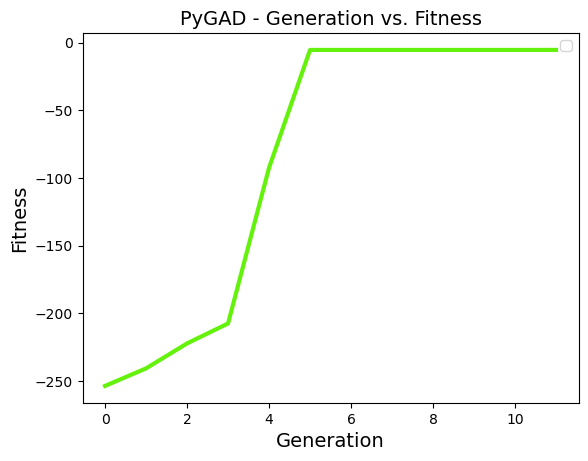

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

ga_instance.run()
ga_instance.plot_fitness()
plt.savefig('plots/figgy.png')